In [1]:
import pandas as pd
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from bct import degree

%load_ext rpy2.ipython

In [97]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(ggseg)
    library(ggsegGlasser)
    library(pals)
    library(patchwork)
    library(tidyverse)
    theme_set(theme_cowplot())
})

options(dplyr.width = Inf)

## Adjacency matrix for right hemisphere

In [67]:
# Load right hemisphere cortical connectome, thresholded to lowest 15% CV edges
data_path = "../data/HCP_Connectome"
RH_cortex_SC = pd.read_table(f"{data_path}/RH_cortex_0.15_CV_density.txt", sep=',', header=None)

# The region to drop corresponds to node index 282
region_lookup_table = (pd.read_csv("../data/Glasser_360_and_subcortex_labels.csv")
                       .assign(Hemi__Region = lambda x: x.Hemisphere + "__" + x.Region_Name)
)

# Fill in the gap for Node_Index so that it is continuous
region_lookup_table = (region_lookup_table
    .query("Node_Index != 282")
    .assign(Node_Index = lambda x: np.where(x.Node_Index > 282, x.Node_Index - 1, x.Node_Index))
    )

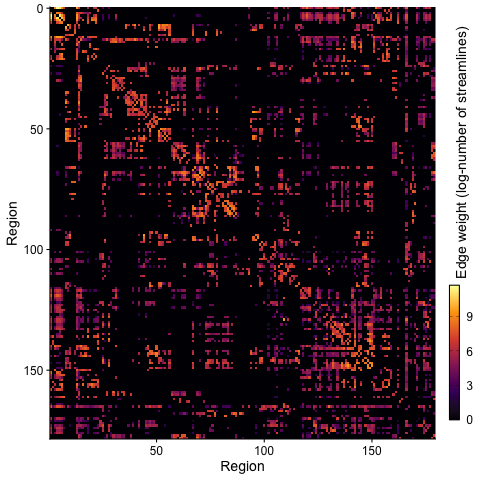

In [63]:
%%R -i RH_cortex_SC -o RH_cortex_SC_long

RH_cortex_SC_long <- RH_cortex_SC %>% 
    mutate(Region1 = row_number()) %>%
    pivot_longer(-Region1, names_to = "Region2", values_to = "SC") %>%
    mutate(Region1 = as.numeric(Region1),
           Region2 = as.numeric(Region2)) %>% 
    filter(Region1 != 91 & Region2 != 91) %>% 
    mutate(Region1 = ifelse(Region1 > 91, Region1 - 1, Region1),
           Region2 = ifelse(Region2 > 91, Region2 - 1, Region2))
           
RH_cortex_SC_long %>%
    ggplot(data=., mapping=aes(x=Region1, y=Region2, fill=SC)) +
    geom_tile() +
    scale_y_reverse(expand=c(0,0)) +
    scale_x_continuous(expand=c(0,0)) +
    scale_fill_viridis_c(option='inferno') +
    ylab("Region") +
    xlab("Region") +
    labs(fill="Edge weight (log-number of streamlines)") +
    theme(legend.key.height = unit(0.95, "cm"),
          legend.title = element_text(angle=90),
            legend.key.width = unit(0.35, "cm")) +
    guides(fill = guide_colourbar(frame.colour = "black", ticks.colour = "black"))
# ggsave("../plots/connectome_analysis/RH_Cortex_SC_matrix.svg", width=5, height=4.5, units='in', dpi=300)

## Network degree vs. strength

In [77]:
node_strengths = degree.strengths_und(RH_cortex_SC.values)
node_degrees = degree.degrees_und(RH_cortex_SC.values)

degree_res_df = (pd.DataFrame({'Strength': node_strengths, 
                              'Degree': node_degrees, 
                              'Node_Index': RH_cortex_SC.index + 191})
                              .merge(region_lookup_table, on='Node_Index', how='left')
                              )

degree_res_df

,Strength,Degree,Node_Index,Region_Name,Base_Region,Hemisphere,Hemi__Region
0,320.788733,52.0,191,R_V1_ROI,V1_ROI,Right,Right__R_V1_ROI
1,45.958381,7.0,192,R_MST_ROI,MST_ROI,Right,Right__R_MST_ROI
2,227.653188,44.0,193,R_V6_ROI,V6_ROI,Right,Right__R_V6_ROI
3,323.827389,57.0,194,R_V2_ROI,V2_ROI,Right,Right__R_V2_ROI
4,364.065378,62.0,195,R_V3_ROI,V3_ROI,Right,Right__R_V3_ROI
...,...,...,...,...,...,...,...
175,239.162368,54.0,366,R_TE1m_ROI,TE1m_ROI,Right,Right__R_TE1m_ROI
176,147.426242,30.0,367,R_PI_ROI,PI_ROI,Right,Right__R_PI_ROI
177,174.107812,43.0,368,R_a32pr_ROI,a32pr_ROI,Right,Right__R_a32pr_ROI
178,146.447508,28.0,369,R_p24_ROI,p24_ROI,Right,Right__R_p24_ROI


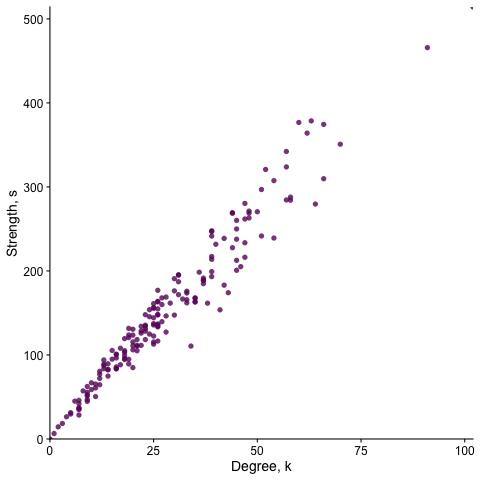

In [78]:
%%R -i degree_res_df

degree_res_df %>% 
    ggplot(data=., mapping=aes(x=Degree, y=Strength)) +
    geom_point(color='#661568', size=2.5, alpha=0.8, stroke=0) +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    ylab("Strength, s") +
    xlab("Degree, k") +
    theme(legend.position = "none") 
# ggsave("../plots/connectome_analysis/RH_Cortex_SC_strength_degree.svg", width=3.5, height=2.7, units='in', dpi=300)

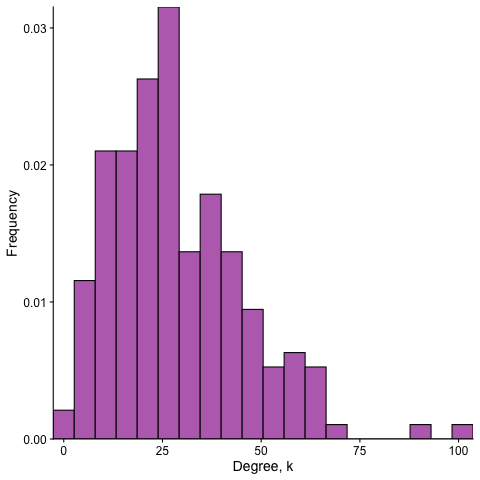

In [59]:
%%R -i degree_res_df

degree_res_df %>% 
    ggplot(data=., mapping=aes(x=Degree)) +
    geom_histogram(aes(y=..density..), fill='#ba70bb', color='black', bins=20) +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    ylab("Frequency") +
    xlab("Degree, k") 
# ggsave("../plots/connectome_analysis/RH_Cortex_SC_degree_histogram.svg", width=3.25, height=2.25, units='in', dpi=300)

In [95]:
%%R -i degree_res_df

# Load Glasser parcellation data
glasser_lookup_table <- glasser %>% as_tibble()

# For Base_Region with multiple rows (ie multiple Module_Number) values, flatten and concatenate Module_Number values 
# Into one string separated by "_"
degree_res_df_glasser = degree_res_df %>%
    mutate(Base_Region = str_replace_all(Base_Region, "_ROI", ""))%>% 
    mutate(Base_Region = paste0("rh_R_", Base_Region)) %>%
    dplyr::rename("label" = "Base_Region") %>% 
    left_join(., glasser_lookup_table)

# Plot node strength on cortical surface with Glasser parcellation
degree_res_df_glasser %>%
  ggplot() +
  geom_brain(atlas=glasser, mapping=aes(fill=Strength),
             hemi = "right") +
  theme_void()  + 
  # scale_fill_discrete(na.translate = F) +
  labs(fill = "Strength, s") +
  scale_fill_viridis_c(option='inferno', na.value='gray80') +
  theme(legend.position="bottom") +
  guides(fill = guide_colourbar(frame.colour = "black", ticks.colour = "black"))
ggsave("../plots/connectome_analysis/node_strength_in_brain_right_cortex.svg", width=4, height=2, units='in', dpi=300)

Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'
In addition: Warning messages:
1: Some data not merged properly. Check for naming errors in data:
  atlas type  hemi  region side  label                 geometry Strength Degree
  <chr> <chr> <chr> <chr>  <chr> <chr>           <MULTIPOLYGON>    <dbl>  <dbl>
1 <NA>  <NA>  <NA>  <NA>   <NA>  rh_R_striatum_1          EMPTY     162.     33
  Node_Index Region_Name  Hemisphere Hemi__Region       
       <int> <chr>        <chr>      <chr>              
1        370 R_striatum_1 Right      Right__R_striatum_1 
2: Some data not merged. Check for spelling mistakes in:
               label Strength Degree Node_Index  Region_Name Hemisphere
198 rh_R_striatum_1 162.0294     33        370 R_striatum_1      Right
           Hemi__Region
198 Right__R_striatum_1 
